# Lab 3: Fourier Transform & Filtering Techniques - Frequency Domain
`By: Sabin Dahal (022bscit035)`

Fourier Transform converts an image from the spatial domain to the frequency domain, representing it as a combination of different frequency components. Frequency domain filtering modifies these components to enhance or suppress details like noise or edges. Common filters include low-pass (for smoothing), high-pass (for sharpening), and band-pass filters. Filtering is done by applying a filter mask to the image’s Fourier transform and then converting it back to the spatial domain using the inverse transform. This technique enables precise and effective image processing.


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
img = cv2.imread('C:/Users/pokha/Downloads/pikachu.png')
img = cv2.cvtColor(cv2.resize(img, (30,30), interpolation=cv2.INTER_LINEAR), cv2.COLOR_BGR2GRAY)

In [4]:
# to show all images in images with their titles
def plot(rows, cols, images, titles):
    plt.figure(figsize=(10,10))
    for i in range(rows):
        for j in range(cols):
            plt.subplot(rows, cols, i * cols + j + 1)
            plt.imshow(images[i*cols+j], cmap='gray')
            plt.title(titles[i*cols+j])
    plt.show()


## Fourier Transform

In [5]:
# Calculating Fourier Transform using standard formula
def dft(img):
    output = []
    M = len(img)
    N = len(img[0])
    for u in range(M):
        row = []
        for v in range(N):
            val = 0
            for x in range(M):
                for y in range(N):
                    angle = -2*math.pi * (u*x/M + v*y/N)
                    val += img[x][y] * complex(math.cos(angle), math.sin(angle))
            val /= (M * N)
            row.append(val)
        output.append(row)
    return np.array(output)

In [6]:
# Calculating Fourier Transform using standard formula
def dftInv(freq_domain):
    M = len(freq_domain)
    N = len(freq_domain[0])
    output = []
    for x in range(M):
        row = []
        for y in range(N):
            val = 0
            for u in range(M):
                for v in range(N):
                    angle = 2 * math.pi * ((u * x) / M + (v * y) / N)
                    val += freq_domain[u][v] * complex(math.cos(angle), math.sin(angle))
            row.append(val)
        output.append(row)
    return np.array(output).real.astype(np.uint8)

In [7]:
# to adjust frequency domain to center and logarithmically scale it (IDK what's going on too)
def log_magnitude_spectrum(freq_domain):
    spectrum = abs(freq_domain)
    return np.log(1 + np.fft.fftshift(spectrum))

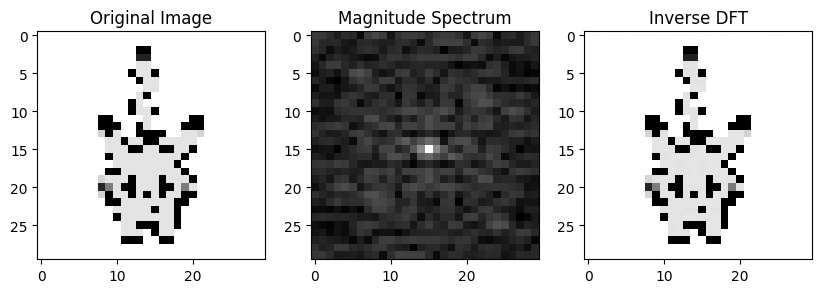

In [8]:
# calculate dft, magnitude spectrum and inverse dft of img (img)
dftTransform = dft(img)
magnitudeSPectrum = log_magnitude_spectrum(dftTransform)
dftInversed  = dftInv(dftTransform)

plot(1, 3, [img, magnitudeSPectrum, dftInversed], ['Original Image', 'Magnitude Spectrum', 'Inverse DFT'])

## Smoothing Frequency Domain Filters

In [9]:
# smoothing using ideal low pass filter
def idealLowPass(freq_domain, cutoff):
    M, N = freq_domain.shape
    filtered = np.zeros((M, N), dtype=complex)
    
    for u in range(M):
        for v in range(N):
            # distance from frequency coordinate from center
            D = np.sqrt((u - M/2)**2 + (v - N/2)**2)
            if D <= cutoff:
                filtered[u, v] = freq_domain[u, v]
            else:
                filtered[u, v] = 0
    return filtered

In [10]:
# smoothing using gaussian low pass filter
def gaussianLowPass(freq_domain, D0):
    M, N = freq_domain.shape
    filtered = np.zeros((M, N), dtype=complex)
    
    for u in range(M):
        for v in range(N):
            H = math.exp(-((u - M/2)**2 + (v - N/2)**2) / (2*D0*D0))
            filtered[u, v] = freq_domain[u, v] * H
    return filtered

In [11]:
# smoothing using butterworth low pass filter
def butterworthLowPass(freq_domain, D0, n):
    M, N = freq_domain.shape
    filtered = np.zeros((M, N), dtype=complex)

    for u in range(M):
        for v in range(N):
            H = 1 / (1 + (math.sqrt((u - M/2)**2 + (v - N/2)**2) / D0)**(2*n*n))
            filtered[u, v] = freq_domain[u, v] * H
    return filtered

In [ ]:
def apply_filter(freq_domain, func, *args):
    # first shift the frequency domain
    F_shifted = np.fft.fftshift(freq_domain)
    # apply filter defined by (func), *args are used to feed extra data a filter might need
    F_filtered = func(F_shifted, *args)
    # unshift updated frequency domain
    F_unshifted = np.fft.ifftshift(F_filtered)
    return F_unshifted

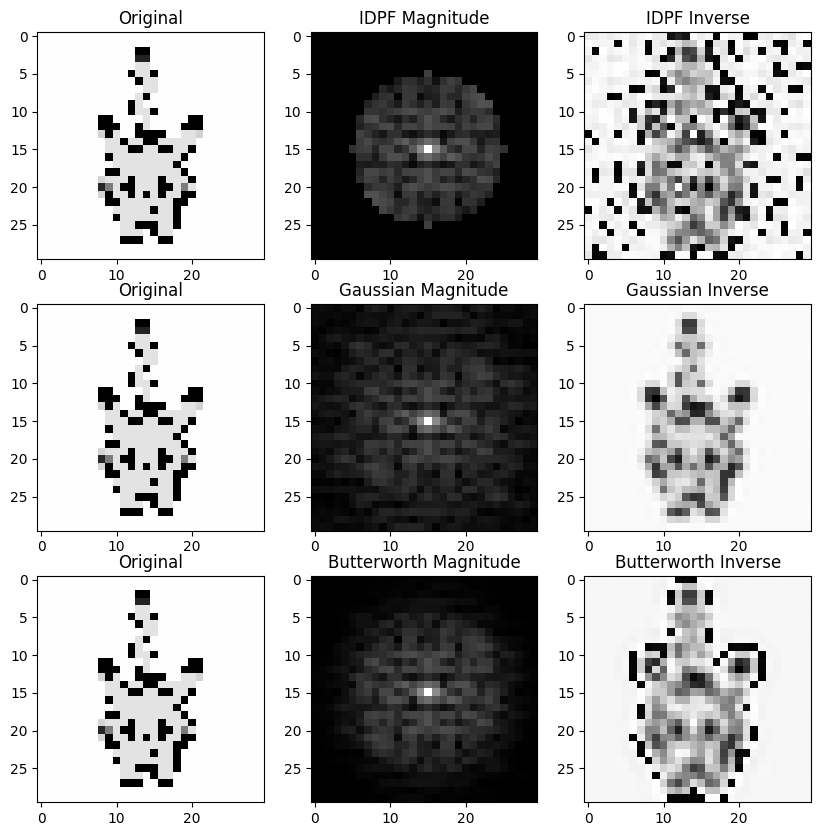

In [ ]:
idpf = apply_filter(dftTransform, idealLowPass, 10)
gaussian = apply_filter(dftTransform, gaussianLowPass, 10)
butterworth = apply_filter(dftTransform, butterworthLowPass, 10, 2)

idpfMag = log_magnitude_spectrum(idpf)
gaussianMag = log_magnitude_spectrum(gaussian)
butterworthMag = log_magnitude_spectrum(butterworth)

idpfInv = dftInv(idpf)
gaussianInv = dftInv(gaussian)
butterworthInv = dftInv(butterworth)

plot(3,3, [img, idpfMag, idpfInv, img, gaussianMag, gaussianInv, img, butterworthMag, butterworthInv], 
    [
        'Original', 'IDPF Magnitude', 'IDPF Inverse',
        'Original', 'Gaussian Magnitude', 'Gaussian Inverse',
        'Original', 'Butterworth Magnitude', 'Butterworth Inverse',
    ])

## Sharpening Frequency Domain Filters

In [ ]:
# sharpening using ideal high pass filter
def idealHighPass(freq_domain, cutoff):
    M, N = freq_domain.shape
    filtered = np.zeros((M, N), dtype=complex)
    
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u - M/2)**2 + (v - N/2)**2)
            if D > cutoff:
                filtered[u, v] = freq_domain[u, v]
            else:
                filtered[u, v] = 0
    return filtered

In [ ]:
# sharpening using gaussian high pass filter
def gaussianHighPass(freq_domain, D0):
    M, N = freq_domain.shape
    filtered = np.zeros((M, N), dtype=complex)
    
    for u in range(M):
        for v in range(N):
            H = 1 - math.exp(-((u - M/2)**2 + (v - N/2)**2) / (2*D0*D0))
            filtered[u, v] = freq_domain[u, v] * H
    return filtered

In [ ]:
# sharpening using butterworth high pass filter
def butterworthHighPass(freq_domain, D0, n):
    M, N = freq_domain.shape
    filtered = np.zeros((M, N), dtype=complex)

    for u in range(M):
        for v in range(N):
            distance = math.sqrt((u - M/2)**2 + (v - N/2)**2)
            if distance==0: distance += 1e-6
            H = 1 / (1 + (D0 / distance)**(2*n*n))
            filtered[u, v] = freq_domain[u, v] * H
    return filtered

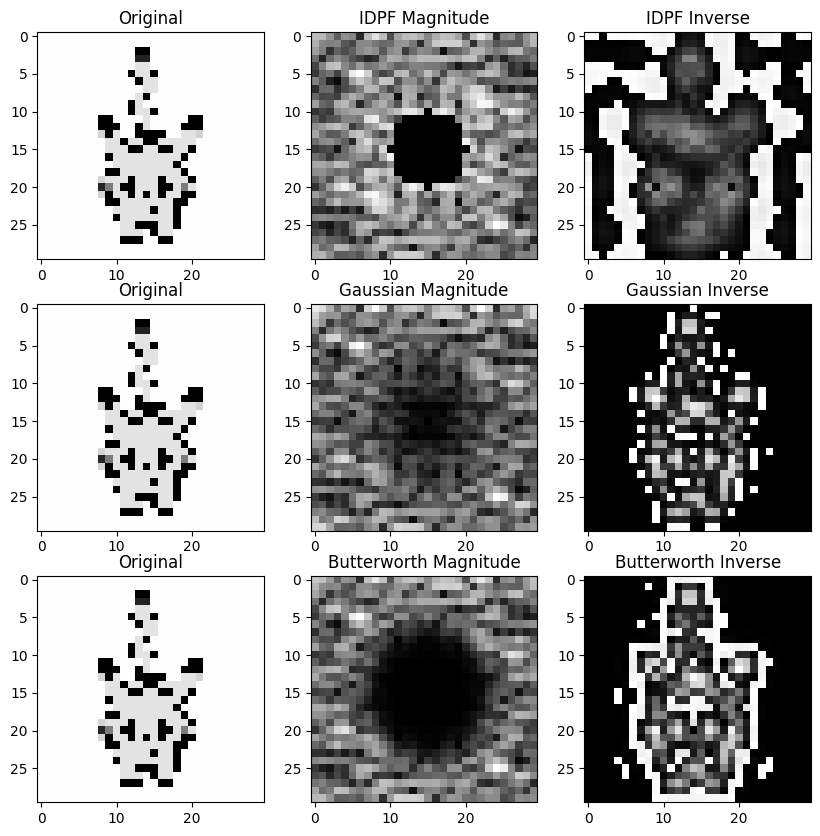

In [ ]:
idpf = apply_filter(dftTransform, idealHighPass, 5)
gaussian = apply_filter(dftTransform, gaussianHighPass, 10)
butterworth = apply_filter(dftTransform, butterworthHighPass, 10, 2)

idpfMag = log_magnitude_spectrum(idpf)
gaussianMag = log_magnitude_spectrum(gaussian)
butterworthMag = log_magnitude_spectrum(butterworth)

idpfInv = dftInv(idpf)
gaussianInv = dftInv(gaussian)
butterworthInv = dftInv(butterworth)

plot(3,3, [img, idpfMag, idpfInv, img, gaussianMag, gaussianInv, img, butterworthMag, butterworthInv], 
    [
        'Original', 'IDPF Magnitude', 'IDPF Inverse',
        'Original', 'Gaussian Magnitude', 'Gaussian Inverse',
        'Original', 'Butterworth Magnitude', 'Butterworth Inverse',
    ])